In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

In [2]:
import sys
sys.path.append(['.'])

from data_provider.data_loader import Dataset_ETT_hour


In [3]:
seq_len = 336
pred_len = 96
label_len = 48

# 1. Evaluate Datasets

In [4]:
train_data = Dataset_ETT_hour(root_path='./dataset/',
                        data_path='ETTh1.csv',
                        flag='train',
                        size=[seq_len,label_len,pred_len],
                        features='S',
                        target='OT',
                        timeenc=1,
                        freq='h')

train_loader = DataLoader(train_data,
                          batch_size=32,
                          shuffle=False,
                          num_workers=10,
                          drop_last=True)

print(train_data.data_x.shape)
print(train_data.data_y.shape)

(8640, 1)
(8640, 1)


In [5]:
vali_data = Dataset_ETT_hour(root_path='./dataset/',
                        data_path='ETTh1.csv',
                        flag='val',
                        size=[seq_len,label_len,pred_len],
                        features='S',
                        target='OT',
                        timeenc=1,
                        freq='h')

vali_loader = DataLoader(vali_data,
                          batch_size=32,
                          shuffle=False,
                          num_workers=10,
                          drop_last=True)

print(vali_data.data_x.shape)
print(vali_data.data_y.shape)

(3216, 1)
(3216, 1)


In [6]:
test_data = Dataset_ETT_hour(root_path='./dataset/',
                        data_path='ETTh1.csv',
                        flag='test',
                        size=[seq_len,label_len,pred_len],
                        features='S',
                        target='OT',
                        timeenc=1,
                        freq='h')

test_loader = DataLoader(test_data,
                          batch_size=32,
                          shuffle=False,
                          num_workers=10,
                          drop_last=True)

print(test_data.data_x.shape)
print(test_data.data_y.shape)

(3216, 1)
(3216, 1)


In [7]:
df_raw = pd.read_csv('./dataset/ETTh1.csv')
df_data = df_raw[['OT']]

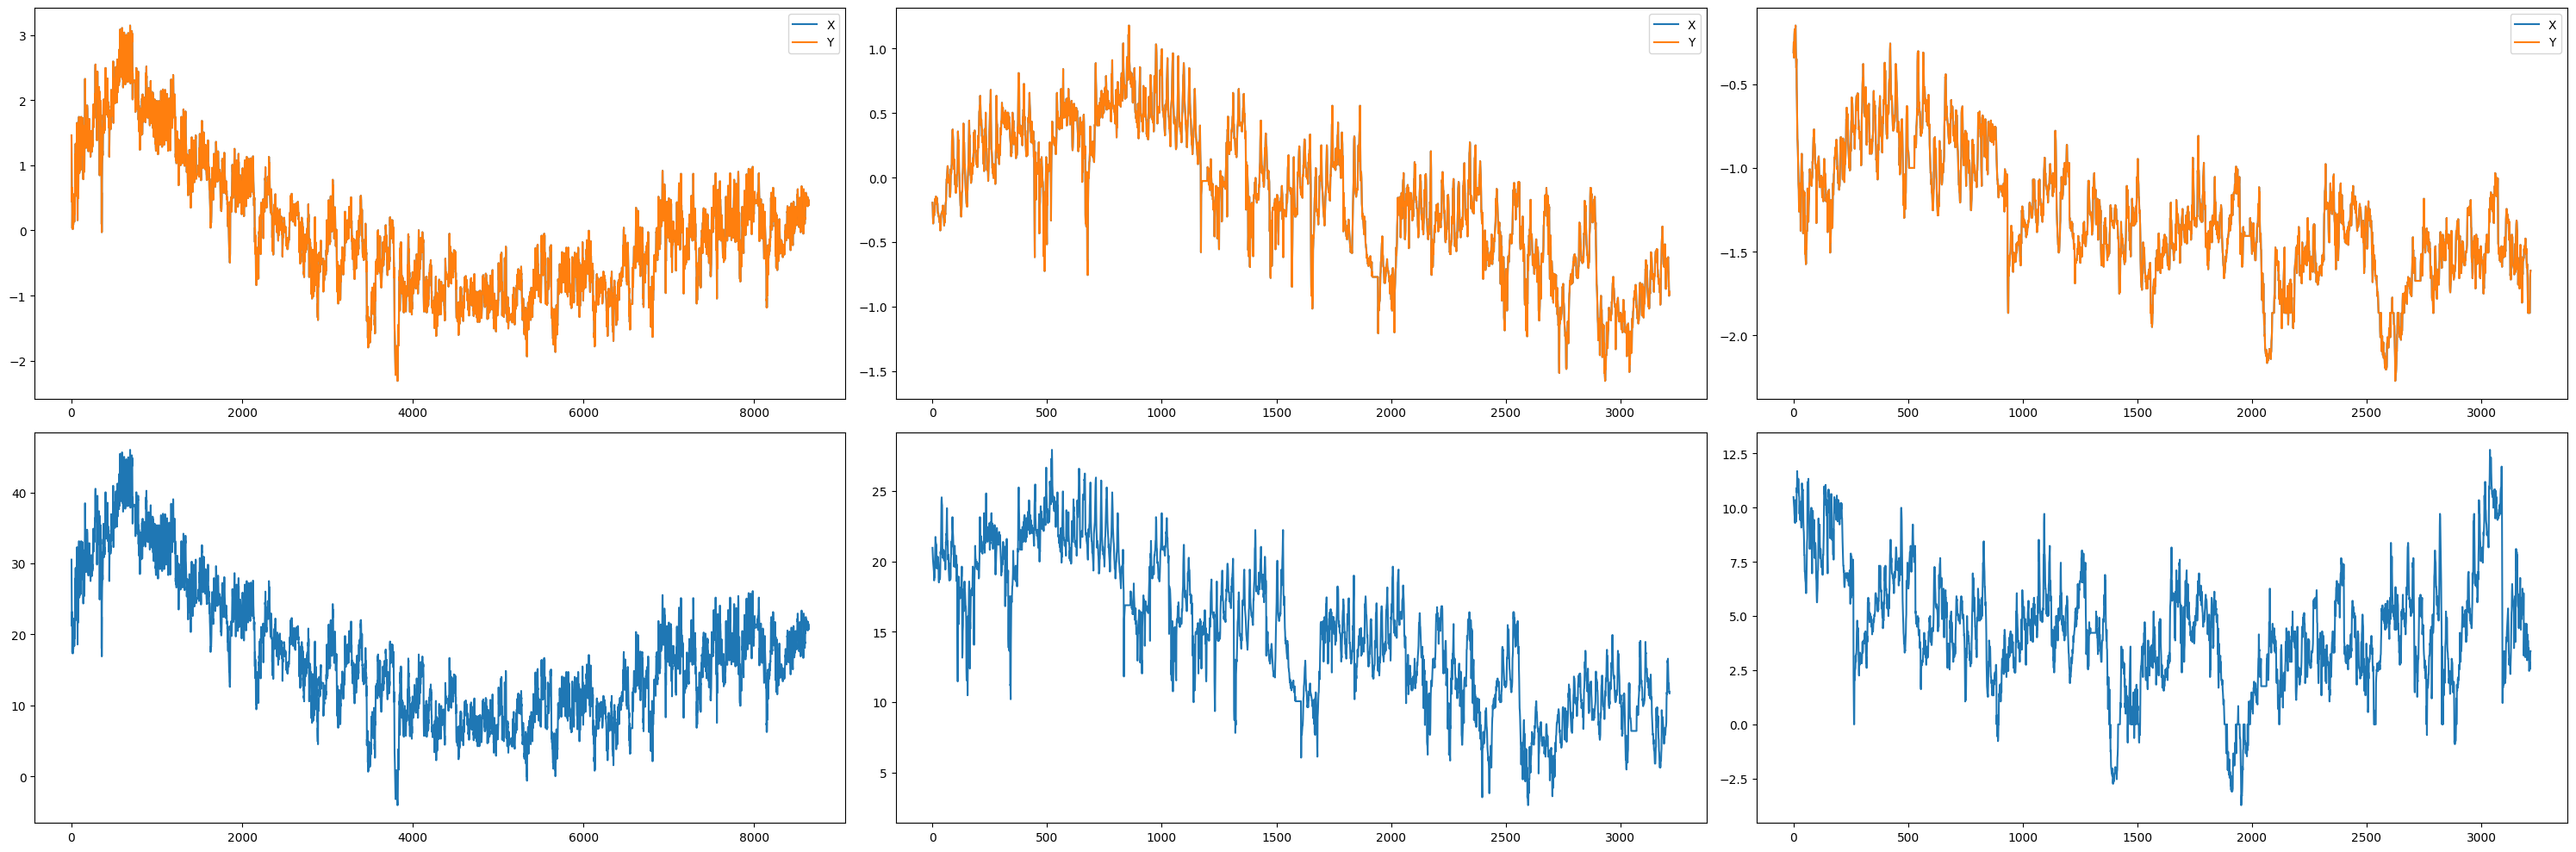

In [8]:
fig, ax = plt.subplots(2,3, figsize=(30,10))

# Train
ax[0,0].plot(train_data.data_x.squeeze(1), label='X')
ax[0,0].plot(train_data.data_y.squeeze(1), label='Y')
ax[0,0].legend()
ax[1,0].plot(df_data[:8640].values)

#Validation
ax[0,1].plot(vali_data.data_x.squeeze(1),  label='X')
ax[0,1].plot(vali_data.data_y.squeeze(1),  label='Y')
ax[0,1].legend()
ax[1,1].plot(df_data[8640:8640+3216].values)

# Test
ax[0,2].plot(test_data.data_x.squeeze(1),  label='X')
ax[0,2].plot(test_data.data_y.squeeze(1),  label='Y')
ax[0,2].legend()
ax[1,2].plot(df_data[8640+3216:8640+3216+3216].values)
plt.tight_layout()
plt.show()


# 2. Load Model

In [9]:
class moving_avg(nn.Module):
    """
    Moving average block to highlight the trend of time series
    """
    def __init__(self, kernel_size, stride):
        super(moving_avg, self).__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=stride, padding=0)

    def forward(self, x):
        # padding on the both ends of time series
        front = x[:, 0:1, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        end = x[:, -1:, :].repeat(1, (self.kernel_size - 1) // 2, 1)
        x = torch.cat([front, x, end], dim=1)
        x = self.avg(x.permute(0, 2, 1))
        x = x.permute(0, 2, 1)
        return x


class series_decomp(nn.Module):
    """
    Series decomposition block
    """
    def __init__(self, kernel_size):
        super(series_decomp, self).__init__()
        self.moving_avg = moving_avg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean


class ESN(nn.Module):

    def __init__(self, 
                 input_size: int,
                #  output_size: int,
                 reservoir_size = 50,
                 activation = nn.Tanh(),
                 *args, **kwargs) -> None:
        super(ESN, self).__init__(*args, **kwargs)

        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.activation = activation


        ## Initialize initial state as a Zero Vector.
        self.state = torch.zeros(self.reservoir_size, 1)

         ## Initialize Input Weights as randomly distributed [-1,1].
        w_p = torch.empty(self.reservoir_size, self.reservoir_size)
        P = nn.init.orthogonal_(w_p)

        w_b = torch.empty(self.reservoir_size, self.input_size)
        B = nn.init.uniform_(w_b, a=-1.0, b=1.0)

        self.W_in = torch.matmul(torch.linalg.inv(P), B)


        ##Initialize Reservoir Weight matrix.
        w_d =  torch.empty(self.reservoir_size)
        d = nn.init.uniform_(w_d, a=-0.95, b=0.95)
        self.W_res = torch.diag(d)

        self.plot_states = self.state.detach().clone()

    ## Calculate states for all inputs.
    def update_state(self, X):
        batch, segments, windown_len  = X.shape
        all_states = torch.empty(batch, segments, self.reservoir_size,)

        for b in range(batch):
            for t in range(segments):
                self.state = self.get_state(X[b, t, :])
                all_states[b,t, :] = self.state.clone().detach().squeeze(1)
                self.plot_states = torch.hstack([self.plot_states, self.state])
        return all_states

        # for i in range(X.shape[0]):
        #     self.state = self.get_state(X[i])
        #     all_states = torch.vstack([all_states, self.state.clone().detach().squeeze(-1)])
        # return all_states


    ## Reset all states for next batch operation.
    def reset_states(self):
        self.state = torch.zeros(self.reservoir_size, 1)
        self.plot_states = self.state.detach().clone()
                    
    ## Calculate state.
    def get_state(self, input):
        input = torch.unsqueeze(input, 1)
        return self.activation(self.W_in@input + self.W_res@self.state)

    def forward(self, X):
        states = self.update_state(X)
        return states



class Model(nn.Module):
    """
    DLinear
    """
    def __init__(self, seq_len, pred_len, individual, enc_in):
        super(Model, self).__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.window_len = 48
        self.reservoir_size = 50

        # Decompsition Kernel Size
        kernel_size = 25
        self.decompsition = series_decomp(kernel_size)
        self.individual = individual
        self.channels = enc_in
        


        if self.individual:
            self.input_linear_layer = nn.ModuleList()
            self.esn_layer = nn.ModuleList()
            self.output_linear_layer = nn.ModuleList()
            for i in range(self.channels):
                self.input_linear_layer.append(nn.Linear(in_features=self.window_len,
                                                   out_features=self.window_len, 
                                                   bias=False))
                self.input_linear_layer[i].weight.requires_grad_ = False
                self.esn_layer.append(ESN(reservoir_size=self.reservoir_size,
                                             activation=nn.LeakyReLU(1.0),
                                             input_size=self.window_len))
                self.output_linear_layer.append(nn.Linear(in_features=self.window_len,
                                                 out_features=self.window_len, 
                                                 bias=False))
        else:
            self.input_linear_layer = nn.Linear(in_features=self.window_len,
                                                   out_features=96, 
                                                   bias=False)
            self.input_linear_layer.weight.requires_grad_ = False
            self.esn_layer = ESN(reservoir_size=self.reservoir_size,
                                             activation=nn.LeakyReLU(1.0),
                                             input_size=96)
            self.output_linear_layer = nn.Linear(in_features=self.reservoir_size,
                                                 out_features=self.pred_len,
                                                 bias=False)


       
    def forward(self, x):
        # x: [Batch, Input length, Channel]
        batch, seq_len, channel = x.shape
        
        # x: [Batch, Channel, Input_length]
        x = x.permute(0,2,1)

        # Calculate total input segments.
        segments = seq_len // self.window_len

        # x: [Batch, Channel, Segments, window_length]
        x = x.view(batch, channel, segments, self.window_len)

        # Calculate prediction segments.
        m = self.pred_len // self.window_len

        if self.individual:
            for i in range(channel):
                x = self.input_linear_layer[i](x[:,i,:,:])
                states = self.esn_layer[i](x)
        else:
            x = x.squeeze(1)
            x = self.input_linear_layer(x)

            # Caapture last of every segment inside the batch.
            states = self.esn_layer(x)[:,-1, :]
            x = self.output_linear_layer(states)
            x = torch.unsqueeze(x, 1)

        return x.permute(0,2,1) # to [Batch, Output length, Channel]
    
    def reset(self):
        self.esn_layer.reset_states()

# 3. Training Model

In [10]:

model = Model(seq_len=seq_len, pred_len=pred_len, individual =0, enc_in=1)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()


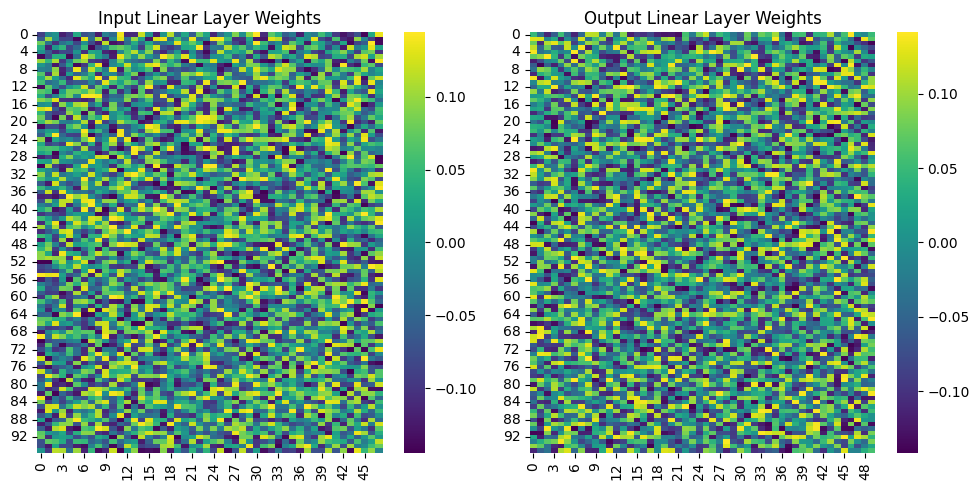

: 

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.heatmap(model.input_linear_layer.weight.detach().numpy(), cmap='viridis', ax=ax[0])
ax[0].set_title('Input Linear Layer Weights')

sns.heatmap(model.output_linear_layer.weight.detach().numpy(), cmap='viridis', ax=ax[1])
ax[1].set_title('Output Linear Layer Weights')
plt.tight_layout()
plt.show()

In [12]:
iter_count = 0
train_loss = []

for _ in range(5):
    iter_count = 0
    train_loss = []
    for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
        iter_count += 1
        batch_x = batch_x.float()
        batch_y = batch_y.float()
        optimizer.zero_grad()

        outputs = model(batch_x)
        outputs = outputs[:, -pred_len:, 1:]
        batch_y = batch_y[:, -pred_len:, 1:]

        loss = criterion(outputs, batch_y)
        train_loss.append(loss.item())
        loss.backward()
        optimizer.step()
    model.reset()
    print(np.average(train_loss))
    print(f"Epoch {_} completed")

nan
Epoch 0 completed
nan
Epoch 1 completed
nan
Epoch 2 completed
nan
Epoch 3 completed


[nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan,
 nan

In [ ]:
model.esn_layer.plot_states.data.shape

torch.Size([2878450, 1])

In [ ]:
for _ in range(9):
    for batch_x, batch_y, batch_x_mark, batch_y_mark in train_loader:
    iter_count += 1
    batch_x = batch_x.float()
    batch_y = batch_y.float()
    optimizer.zero_grad()

    outputs = model(batch_x)
    outputs = outputs[:, -pred_len:, 1:]
    batch_y = batch_y[:, -pred_len:, 1:]

    loss = criterion(outputs, batch_y)
    loss.backward()
    optimizer.step()

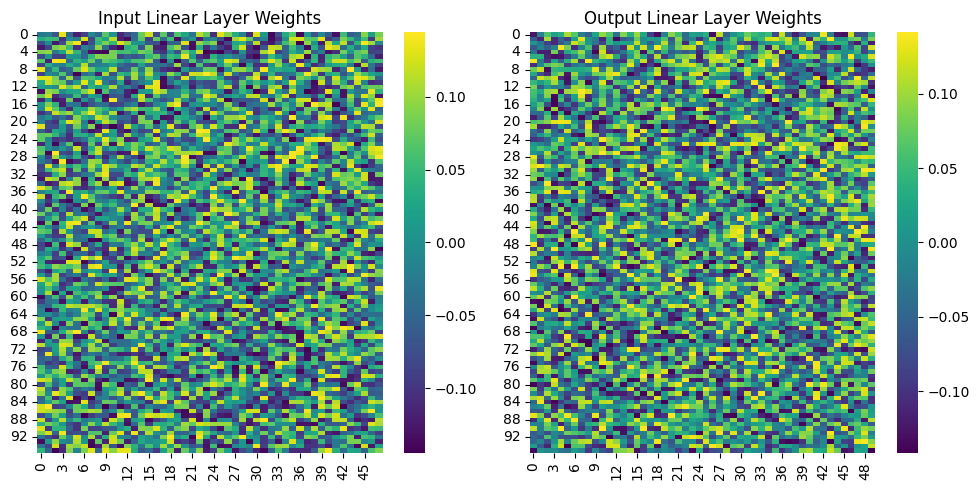

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,5))
sns.heatmap(model.input_linear_layer.weight.detach().numpy(), cmap='viridis', ax=ax[0])
ax[0].set_title('Input Linear Layer Weights')

sns.heatmap(model.output_linear_layer.weight.detach().numpy(), cmap='viridis', ax=ax[1])
ax[1].set_title('Output Linear Layer Weights')
plt.tight_layout()
plt.show()